# Загрузка библиотек

In [3]:
import pandas as pd
import requests
import urllib
import json
import seaborn as sns
from urllib.parse import urlencode
import requests
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import norm

from tqdm.auto import tqdm

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import pingouin as pg

%matplotlib inline

# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [4]:
def retention(start, end, num_days):
    #Данные о времени регистрации
    df_reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
    #Данные о времени захода пользователей в игру
    df_log = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')
    
    #Так как мы считаем по дням от даты регистрации, а не по 24-ым часовым интервалам, 
    #можно избавиться от времени и оставить только дату
    df_reg ['reg_ts'] = pd.to_datetime(df_reg.reg_ts, unit='s').dt.date
    df_log ['auth_ts'] = pd.to_datetime(df_log.auth_ts, unit='s').dt.date
    
    #соединим заходы пользователей с их датой регистрации 
    df_all = df_log.merge(df_reg, how = 'inner', on = 'uid') 
    #посчитаем разницу между датой захода и регистарцией
    df_all ['days'] = (df_all.auth_ts - df_all.reg_ts).dt.days.astype('int16')
    
    #фильтруем по интересующему интерварлу 
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    num_days= num_days
    
    df_ret = df_all[(df_all['reg_ts']>=start)&(df_all['reg_ts']<=end)&(df_all['days']<=num_days)]
    
    #считаем колличество уников по когортам 
    df_ret = df_ret.groupby(['reg_ts', 'days'], as_index=False) \
                       .agg({'uid': 'nunique'}) 
    
    #пивотим для удобства 
    retention = df_ret.pivot(index='reg_ts', columns='days', values='uid')
    
    #считаем ретеншн по отношению к первому дню и заполняем нули 
    cohort = retention.iloc[:,0]
    retention = retention.divide(cohort, axis=0)
    retention = retention.round(2).fillna(0)
    
    plt.figure(figsize=(24, 24))
    plt.title("Cohorts: User Retention")
    ax = sns.set(style="ticks")
    ax = sns.heatmap(retention, cmap=sns.cubehelix_palette(as_cmap=True), mask=retention.isnull(), annot=True, fmt=".0%",\
                     annot_kws={"size": 14})
    ax.xaxis.tick_top()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


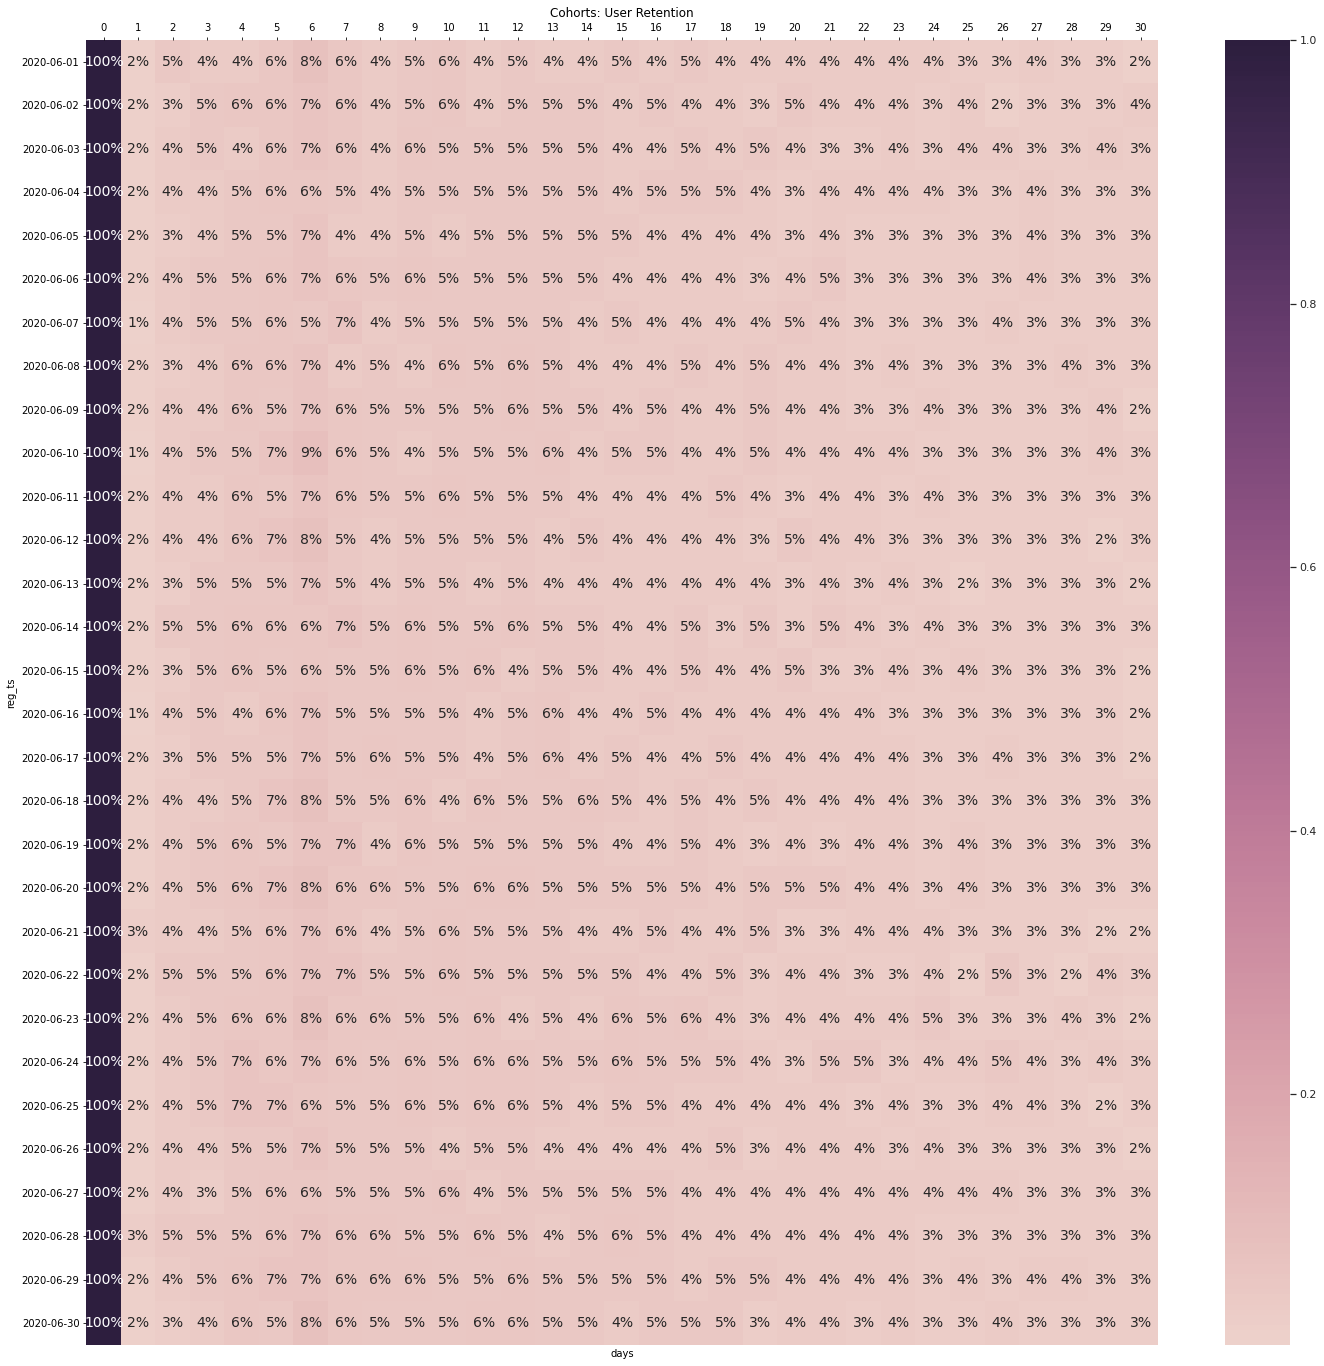

In [5]:
#Введите данные в функцию ('первая когорта', 'последняя когорта', кол-во дней с регистрации)
retention ('2020-06-01','2020-06-30', 30)

-----------------------------------------------------------------

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [6]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
df_AB = pd.read_csv(requests.get(final_url).json()['href'], sep = ';')

In [7]:
df_AB

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Разделим датасет по группам:

In [8]:
control = df_AB[df_AB.testgroup == "a"]

In [9]:
test = df_AB[df_AB.testgroup == "b"]

Посмотрим на описательные стат. двух групп.

In [10]:
test.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


In [11]:
control.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


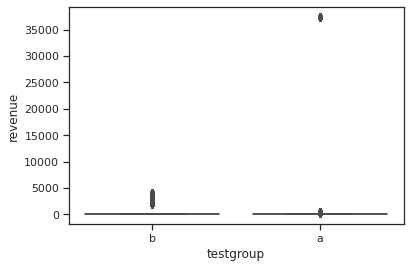

In [12]:
#видно уже тут, что распределение данных вряд ли нормальное и есть большой выброс в контрольной группе.
sns.boxplot (x = 'testgroup', y = 'revenue', data = df_AB)

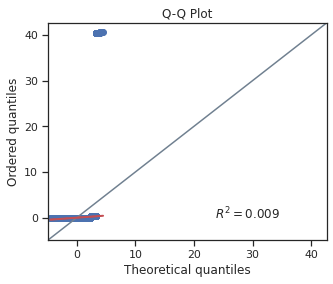

In [13]:
pg.qqplot(control.revenue)

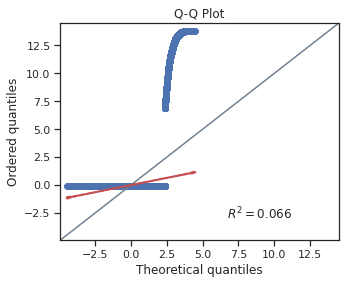

In [14]:
pg.qqplot(test.revenue)

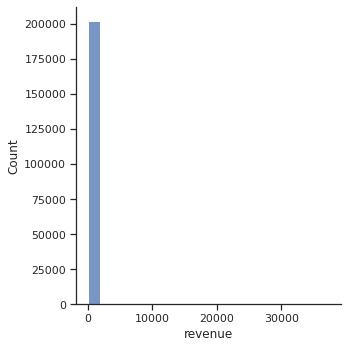

In [15]:
sns.displot(control, x="revenue")

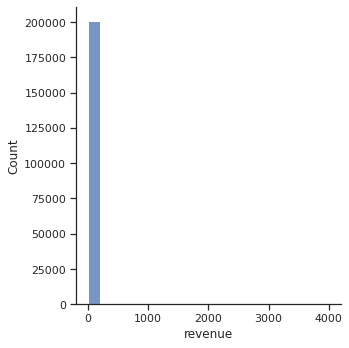

In [16]:
sns.displot(test, x="revenue")

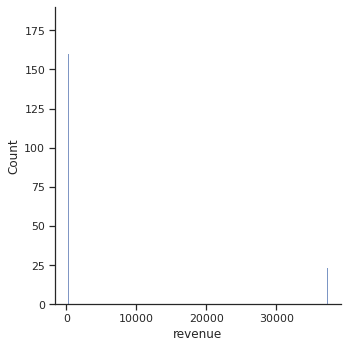

In [17]:
sns.displot(control[control.revenue > 0], x="revenue")

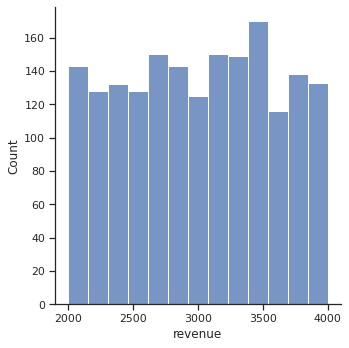

In [18]:
 sns.displot(test[test.revenue > 0], x="revenue")

Мы видим, что оба распределения ненормальные, поэтому можем сразу откинуть все параметрические критерии для проверки гипотез. Так как нас тут интересует равенство средних (спойлер: и медиан) я всё-таки остановлюсь на бутстрепе. Почему не Манна-Уитни? Критерий Манна-Уитни с H0 берёт именно утверждение о том,  что распределения равны. Мне кажется, такая гипотеза не совсем актуальна для нашей бизнес-задачи. Нас всё-таки интересует ARPU. 
Давайте проверим гиптезу о равенстве средних среди платящих и неплатящих юзеров в тествой и контрольной группе: 

- $H_0$: средние равны
- $H_1$: средние не равны

In [19]:
# Объявим функцию, которая позволит проверять гипотезы со средними с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    ) 
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

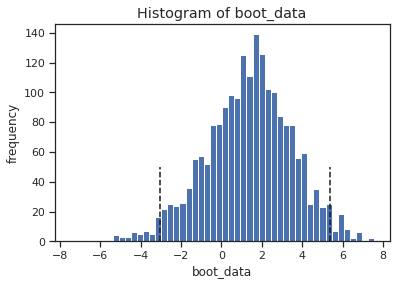

In [20]:
booted_data = get_bootstrap(test.revenue, control.revenue, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [21]:
booted_data["p_value"]

0.5230846607050754

In [22]:
booted_data["ci"]

,0
0.025,-3.028634
0.975,5.369816


Промежуточный вывод  #1: мы принимаем нулевую гипотезу и делаем вывод, что наша средние одинаковые. 


Оставлять ли нам в таком случае наш старый набор акционных предложений? 

Меня слишком смущает распределение в контрольной группе, где к нас есть довольно сильный выброс, где примерно 50 человек потратили в игре больше 30000, в то время как большинство чуть-чуть больше нуля. Такой выброс точно повлиял на среднюю. Мне кажется, тут будет более репрезентативно смотреть на медиану, так как она менее подвержена выборосам. Плюс, как мы знаем пользователи-киты являются случайной величиной и ориентироваться в расчётах на них немного рискованно. Мне бы не хотелось убирать их вообще из выборки, так как они всё-таки значимо влияют на картину и их довольно много. Но нужно как-то сократить их влияние на наши результаты.

И более того, мы видим что медиана в обеих группах одинаковая и равняется нулю (потому что у нас очень и очень много не платящей аудитории). А что если мы уберём не платящих юзеров? 

In [23]:
control_2 = control[control.revenue > 0]

In [24]:
test_2 = test[test.revenue > 0]

In [25]:
control_2.shape

(1928, 3)

In [26]:
test_2.shape

(1805, 3)

In [27]:
test_2.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


In [28]:
control_2.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


Мы видим, что медианы различаются очень сильно (3022 в тестовой и 300 рублей в контрольной). Давайте проверим, является ли данное различие стат.значимым? И тоже будем использовать бутстрап, так как он опять же лучше подходит нам по проверяемой нулевой гипотезе. 

- $H_0$: медианы у платящих равны
- $H_1$: медианы у платящих не равны

In [29]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

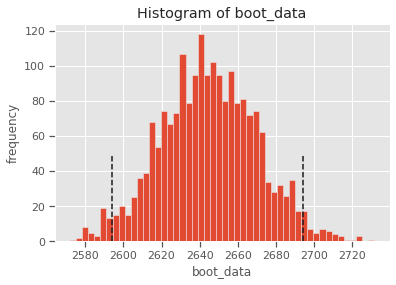

In [30]:
booted_data = get_bootstrap_median(test_2.revenue, control_2.revenue, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [31]:
booted_data["p_value"]

0.0

In [32]:
booted_data["ci"]

,0
0.025,2594.0
0.975,2694.0


Промежуточный вывод  #2: мы отклоняем нулевую гипотезу и делаем вывод, что наша медианы платящих юзеров различаются. В тестовой группе медианная прибыль значимо больше. 

# Выводы:

Что бы я посоветовала сделать? Во-первых, в контрольной группе у нас какие-то очень разные юзеры, одни тратят  чуть больше 0, другие больше 30000. Такой сильный разброс в группе немного мешает делать выводы и сравнивать их с данными группы экспериментальной. Есть ощущение, что в контрольную группы к нам из платящих к нам попали одни "киты" и "карпы", а в тестовую только "дельфины". У нас точно всё было хорошо на стороне проведения теста? 

Во-вторых, как мы видим, что в целом по ARPU различий нет, но есть большие различия в ARPPU. Может иметь смысл провести эксперимент именно среди них? Да мы сейчас что-то проверили сами, но можно ли доверять нашему бустрепу с платящими юзерами, ведь изначально выборка проектировалась именно на проверку влияния ARPU. 
Если у нас есть ресурсы на это, идеально было бы всё-таки проверить именно юзеров платящих. 


Если проводить ещё АБ текст никому не хочется, то я бы всё-таки бы выкатила новые наборы акционных предложений. Я думаю, это всё-таки увеличит наши доходы. 

--------------------------------------

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Конечно, набор метрик для оценки  результаты последнего прошедшего события очень сильно зависит от модели монетизации игры. Где-то нам бы важнее было длинна сессии и количество просмотренных рекламных роликов, а где-то мы бы больше следили за влиянием события на ARPU/ARPPU. Предположим, то у нас **free-to-play** игра со **внутриигровыми покупками** и **встроенной рекламой**, так как сейчас это наиболее распространённая модель монетизации в мобильных играх. В данном случае, нам будет особенно важно проследить повлияло ли наше последнее событие и на удержание, и на метрики монетизации. 


Первое что нужно будет посмотреть, это собственно **конверсию** в начало прохождения тематического события. То есть ответить на вопрос: Сколько наших уникальных юзеров вообще решили пройти дополнительные уровни?  Также, можно построить $воронку$, которая описывает конверсию в дальнейшие уровни. Это поможет увидеть на каком уровне нашего события отваливаются пользователи и достаточно ли сбалансированы наши доп. уровни, чтобы пользователям было интересно, но и не слишком уж сложно. Конечно, нам также важно посмотреть как в целом доп. уровни влияют на базовые метрики нашего приложения. 


В зависимости от длинны события и количество уровней в нём, можно посмотреть  **Retention** 1 дня и/или Retention 3 дня и/или  Retention 7 дня (начиная с запуска тематического события, можно смотреть этот Retention по когортам, если дней много). Важно также проверить, а увеличивает ли событие наши **DAU** и **MAU** по сравнению с днями и месяцами, когда тематических событий нет. Можно также сравнить среднюю длину сессии за неделю с неделей без события. Стал ли наш пользователь проводить больше времени в игре? Ну и конечно проверить, а помогает ли наше событие увеличить нашу прибыль? Как раздача дополнительных монет и бонусов влияет на **ARPU** и **ARPPU**. Наш игрок теперь не хочет покупать ничего из магазина или наоборот теперь с новыми предметами больше замотивирован улучшить свой уровень?


Если мы усложнили механику событий, я бы оставила все предыдущее метрики, но уже гораздо бы внимательней смотрела бы, на воронку конверсии в следующие уровни и **winrate** уровней. Возможно, также дополнительно нужно было бы смотреть на **churn-rate** после события по всей игре в целом. Вдруг, наше тематическое событие не принесло пользователю приятное чувство победы, а раздражающее чувство поражения и теперь он или она совсем разочаровались в нашей игре :) 
Небольшое дополнение, все вышестоящие метрики можно смотреть в разрезе сегментаций, которые уже у нас есть в продукте. Например, посмотрела бы на метрики в разрезе  бесплатных игроков,  «карпов»,  «дельфинов» и  «китов».